In [1]:
import os
import glob
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms

# Data Loading

In [2]:
class dataset(Dataset):

    def __init__(self, image_root, label_root, img_x, img_y):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        self.images_path = image_root
        self.labels_path = label_root
        self.data_len = 0
        self.images = []
        self.labels = open(self.labels_path, "r").readlines()
        self.transform = transforms.Compose([
            transforms.Resize((img_x, img_y)),  
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        for root, dirs, files in os.walk(self.images_path):
            for file in files:
                if file.endswith('.png'):
                    self.data_len += 1
                    temp = file.split("-")
                    self.images.append(self.images_path + temp[0] + '/' + temp[0] + "-" + temp[1] + "/" + file)

    def __len__(self):
        """return number of points in our dataset"""
        return(self.data_len)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """
        img = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img)
        img = img.convert('RGB')
        img = self.transform(img)
        return(img, label[:-1])

In [3]:
def loader_param():
    img_x = 32
    img_y = 32
    batch_size = 8
    return(img_x, img_y, batch_size)

In [4]:
img_x, img_y, batch_size = loader_param()
train_set = dataset(image_root="./IAM Dataset/words/", label_root = "./IAM Dataset/ascii/labels.txt", img_x = img_x, img_y = img_y)
# train_set.__getitem__(345)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

## Sample visualisation

In [5]:
train_iter = iter(train_loader)

In [6]:
samples, labels = train_iter.next()

In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


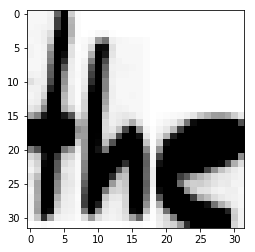

In [8]:
trial_num = np.random.randint(0, batch_size)
imshow(samples[trial_num])

In [9]:
labels[trial_num]

'the'

## Cuda Support

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
torch.cuda.empty_cache()
# device = "cpu"

# Model

In [11]:
class Enc_Dec(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # General Parameters
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.softmax = nn.LogSoftmax(dim = 2)
        
        # Encoder CNN Model
        self.cnn_net = nn.Sequential(
            nn.Conv2d(3, 4, 5, padding = 2), # (N, 3, 32, 128) -> (N, 4, 32, 128)
            nn.ReLU(),
            nn.Conv2d(4, 8, 5, padding = 2), # (N, 4, 32, 128) -> (N, 8, 32, 128)
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding = 1), # (N, 8, 32, 128) -> (N, 16, 32, 128)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding = 1), # (N, 16, 32, 128) -> (N, 32, 32, 128)
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding = 1) # (N, 32, 32, 128) -> (N, 32, 32, 128)
        )
        
        # Decoder RNN Model
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.init_hidden = (torch.zeros(1, 1, self.hidden_size, device = device), torch.zeros(1, 1, self.hidden_size, device = device))
    
    def cnn_model(self, input_):       
        return(self.cnn_net(input_))
    
    def rnn_model(self, input_, hidden):
        out, hidden = self.lstm_cell(input_, hidden)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return(output, hidden)
    
    def forward(self, input_):
        encoding = self.cnn_model(input_)
#         decodings = []
        decodings_tensor = None
        for i in range(encoding.shape[0]):
#             image_decoding = [] 
            hidden = self.init_hidden
            image_decoding_tensor = None
            for j in range(encoding.shape[3]):
                rnn_input = encoding[i, :, :, j]
                decoding, hidden = self.rnn_model(rnn_input.view(1, 1, -1), hidden)
#                 image_decoding.append(decoding)
                if image_decoding_tensor is None:
                    image_decoding_tensor_size = list(decoding.size())
                    image_decoding_tensor_size.insert(0, encoding.shape[3])
                    image_decoding_tensor = torch.empty(*image_decoding_tensor_size, dtype=decoding.dtype, device=decoding.device)

                image_decoding_tensor[j, :] = decoding   
#             decodings.append(image_decoding)
            if decodings_tensor is None:
                decodings_tensor_size = list(image_decoding_tensor.size())
                decodings_tensor_size.insert(0, encoding.shape[0])
                decodings_tensor = torch.empty(*decodings_tensor_size, dtype=image_decoding_tensor.dtype, device=image_decoding_tensor.device)

            decodings_tensor[i, :] = image_decoding_tensor
        decodings_tensor = torch.squeeze(decodings_tensor)
        decodings_tensor.transpose_(0, 1)
        return(decodings_tensor)

In [12]:
img_txt = Enc_Dec(input_size = 32 * img_x, hidden_size = 256, output_size = 79).to(device)

In [13]:
%%time
decodings = img_txt.forward(input_ = samples.to(device))

Wall time: 1.02 s


In [14]:
decodings.shape

torch.Size([32, 8, 79])

# Train Setup

## Data Management

In [15]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"!#&\'()*+,-./0123456789:;?'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52, '"': 53, '!': 54, '#': 55, '&': 56, "'": 57, '(': 58, ')': 59, '*': 60, '+': 61, ',': 62, '-': 63, '.': 64, '/': 65, '0': 66, '1': 67, '2': 68, '3': 69, '4': 70, '5': 71, '6': 72, '7': 73, '8': 74, '9': 75, ':': 76, ';': 77, '?': 78}


In [16]:
def word_rep(word, letter2index, max_out_chars, device = 'cpu'):
    rep = torch.zeros(max_out_chars).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index] = pos
    pad_pos = letter2index[pad_char]
    rep[letter_index+1] = pad_pos
    return(rep, len(word))

In [17]:
def words_rep(labels_str, max_out_chars = 20, batch_size = batch_size):
    words_rep = []
    output_cat = None
    lengths_tensor = None
    lengths = []
    for i, label in enumerate(labels_str):
        rep, lnt = word_rep(label, eng_alpha2index, max_out_chars, device)
        words_rep.append(rep)
        if lengths_tensor is None:
            lengths_tensor = torch.empty(len(labels_str), dtype= int)
        if output_cat is None:
            output_cat_size = list(rep.size())
            output_cat_size.insert(0, len(labels_str))
            output_cat = torch.empty(*output_cat_size, dtype=rep.dtype, device=rep.device)
#             print(output_cat.shape)

        output_cat[i, :] = rep
        lengths_tensor[i] = lnt
        lengths.append(lnt)
    return(output_cat, lengths_tensor)

## Training

In [26]:
def train(epochs = 10, lr = 0.01):
    loss_fn = nn.CTCLoss()
    img_txt = Enc_Dec(input_size = 32 * img_x, hidden_size = 1024, output_size = 79).to(device) 
    optm = optim.SGD(img_txt.parameters(), lr=lr, momentum = 0.9)
    
    input_lengths = torch.full(size=(batch_size,), fill_value=img_y, dtype=torch.long)
    for i in range(epochs):
        total_loss = 0
        for j, (images, labels_str) in enumerate(iter(train_loader)):
            labels, target_lengths = words_rep(labels_str, max_out_chars = 20, batch_size = batch_size)
            images = images.to(device) 
            decodings = img_txt.forward(images)
            print("Label: ", labels[0], '\nOutput: ', torch.argmax(decodings[:, 0, :], 1), '\nTarget len: ', target_lengths[0].item())
#             prob_decodings = nn.functional.log_softmax(decodings, dim = 1)
            loss = loss_fn(decodings, labels, input_lengths, target_lengths)
            
            img_txt.train()
            optm.zero_grad()
            loss.backward()
            optm.step()
            
            torch.cuda.empty_cache()
            total_loss += loss
            print(loss.item(), "\n\n")
        print("Avg Loss for epoch {} is {}\n\n".format(i, total_loss / j))

In [27]:
train()

Label:  tensor([35., 46., 45., 31., 38., 32.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([56, 35, 35, 35, 35, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
        75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 35],
       device='cuda:0') 
Target len:  6
36.218177795410156 


Label:  tensor([48., 31., 44., 45., 35., 41., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  7
60.56248092651367 


Label:  tensor([35., 32.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  2
39.54811096191406 


Lab

        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  9
3.9231228828430176 


Label:  tensor([46., 34., 31., 39., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  5
4.304357528686523 


Label:  tensor([34., 27., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
4.085022926330566 


Label:  tensor([ 5., 48., 31., 44.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='c

Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
3.939146041870117 


Label:  tensor([ 9., 46.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  2
3.9773967266082764 


Label:  tensor([39., 31., 40., 46.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
3.8230302333831787 


Label:  tensor([44., 31., 39., 27., 35., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 

         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  5
4.292814254760742 


Label:  tensor([23., 34., 27., 46.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
4.573568820953369 


Label:  tensor([9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
4.156675338745117 


Label:  tensor([62.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output

Label:  tensor([34., 31., 44., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
4.950433731079102 


Label:  tensor([48., 47., 38., 33., 27., 44.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  6
7.944745063781738 


Label:  tensor([ 7., 35., 47., 45., 31., 42., 42., 31.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  8
6.323026657104492 


Label:  tensor([27., 40., 30.,  0.,  0.,  0

         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  10
12.007701873779297 


Label:  tensor([45., 42., 41., 37., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  5
14.755244255065918 


Label:  tensor([16., 44., 41., 32., 35., 46., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0') 
Target len:  7
12.902321815490723 


Label:  tensor([28., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,


         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([41, 41, 41, 41, 41, 41,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0') 
Target len:  1
16.595138549804688 


Label:  tensor([ 5., 30., 35., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([41, 41, 41, 41, 41, 41,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0') 
Target len:  4
7.999673843383789 


Label:  tensor([16., 15., 23.,  5., 18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([34, 46, 45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0') 
Target len:  5
13.141337394714355 


Label:  te

         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([41,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0') 
Target len:  8
5.4851579666137695 


Label:  tensor([41., 32.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  2
6.172918319702148 


Label:  tensor([64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([41,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0') 
Target len:  1
5.704815864562988 


Label:  tensor([31., 32., 32., 31., 29., 46.,  0.,

4.4160871505737305 


Label:  tensor([49., 27., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
5.866268157958984 


Label:  tensor([64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
4.693068981170654 


Label:  tensor([27.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
6.536903381347656 


Label:  tensor([46., 

        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  2
5.281886577606201 


Label:  tensor([64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
6.7781219482421875 


Label:  tensor([62.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
5.171469211578369 


Label:  tensor([42., 41., 46., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='c

         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
4.638461112976074 


Label:  tensor([45., 41., 39., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
4.2372870445251465 


Label:  tensor([28., 31., 29., 27., 47., 45., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  7
4.679521560668945 


Label:  tensor([ 2., 44., 35., 30., 33., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], dev

4.474170684814453 


Label:  tensor([49., 34., 41.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
3.977820873260498 


Label:  tensor([41., 32.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  2
4.975215911865234 


Label:  tensor([46., 34., 35., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
4.126239776611328 


Label:  tensor([19., 3

        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
4.052712440490723 


Label:  tensor([62.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
4.368193626403809 


Label:  tensor([39., 27., 44., 44., 35., 27., 33., 31.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  8
4.8926239013671875 


Label:  tensor([39., 27., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='c

        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
6.995033264160156 


Label:  tensor([64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
10.553436279296875 


Label:  tensor([27., 28., 41., 47., 46.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  5
11.858871459960938 


Label:  tensor([46., 34., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='

         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
6.301045894622803 


Label:  tensor([34., 27., 40., 30., 35., 40., 33.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  7
5.4931440353393555 


Label:  tensor([33., 44., 41., 49., 35., 40., 33.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  7
7.131907939910889 


Label:  tensor([49., 35., 46., 34.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], dev

6.441476821899414 


Label:  tensor([78.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
7.827380180358887 


Label:  tensor([14., 41., 49.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
7.69739294052124 


Label:  tensor([27., 38., 38.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
6.039462089538574 


Label:  tensor([29., 41

        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
4.465379238128662 


Label:  tensor([46., 34., 31., 51.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
4.0486555099487305 


Label:  tensor([64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
3.9526405334472656 


Label:  tensor([46., 34., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='

         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  7
4.1115031242370605 


Label:  tensor([9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
7.5437211990356445 


Label:  tensor([27., 38., 38.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
5.928633689880371 


Label:  tensor([62.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Outp

        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  7
7.589896202087402 


Label:  tensor([42., 44., 41., 42., 31., 44., 38., 51.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  8
5.142611503601074 


Label:  tensor([19., 34., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
14.340715408325195 


Label:  tensor([27., 30., 30., 31., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='c

         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
8.410409927368164 


Label:  tensor([30., 31., 27., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
7.714907646179199 


Label:  tensor([28., 31.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  2
7.7180495262146 


Label:  tensor([32., 41., 44.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device

Label:  tensor([62.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
18.442214965820312 


Label:  tensor([63.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
10.600679397583008 


Label:  tensor([58.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  1
6.9489641189575195 


Label:  tensor([64.,  0.,  0.,  0.,  0.,

        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  3
7.2586259841918945 


Label:  tensor([43., 47., 35., 29., 37., 38., 51.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  7
5.621783256530762 


Label:  tensor([ 5., 48., 31., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') 
Target len:  4
5.725893020629883 


Label:  tensor([64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0') 
Output:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='c

IndexError: index 20 is out of bounds for dimension 0 with size 20

In [28]:
decodings = img_txt.forward(samples.to(device))

In [29]:
decodings.shape

torch.Size([32, 8, 79])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


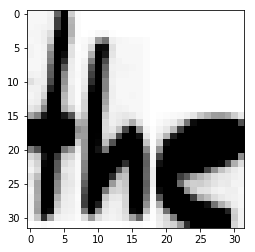

In [30]:
imshow(samples[0])

In [31]:
torch.argmax(decodings, 1)[:, 0]

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2,
        2, 4, 2, 2, 2, 2, 5, 0], device='cuda:0')

In [ ]:
rep, _ = words_rep(['Sriram', 'Pingali'])

In [ ]:
rep.shape